# Final Model : XGBOOST
---


# LOS TRES TENSORES
- Pedro Dimas Martínez
- Juan Contell Husillos
- Rafael Domenech Serrano

---

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(989)

url = "hunger_data.csv"
dataframe = pd.read_csv(url, header=0)
dataframe.drop("Unnamed: 0", axis=1, inplace=True)
dataframe.columns = ["refractive_index", "sodium", "magnesium", "aluminum", "silicon", "potassium", "calcium", "barium", "iron", "type_of_glass"]

X = dataframe.drop(columns="type_of_glass") #Features
y = dataframe["type_of_glass"] #Target

X_train, X_test, y_train, y_test = train_test_split(X, y)

# This model does not require normalisation
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# The Model
---

                [ XGBOOST ]
Default score: ----------------------------------------------------------------------
 Train: 1.000
 Test: 0.767
Other scores: ----------------------------------------------------------------------
 Accuracy  : 0.767
             [1 2 3 5 6 7]
 Precision : [0.63636364 0.66666667 1.         1.         1.         1.        ]
 Recall    : [0.875      0.6        0.66666667 1.         0.66666667 1.        ]
 F1        : [0.73684211 0.63157895 0.8        1.         0.8        1.        ]
 F1 micro  : 0.767
 F1 macro  : 0.828
 Balanced accuracy: 0.801
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.64      0.88      0.74         8
           2       0.67      0.60      0.63        10
           3       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         1
           6       1.00      0.67      0.80         3
          

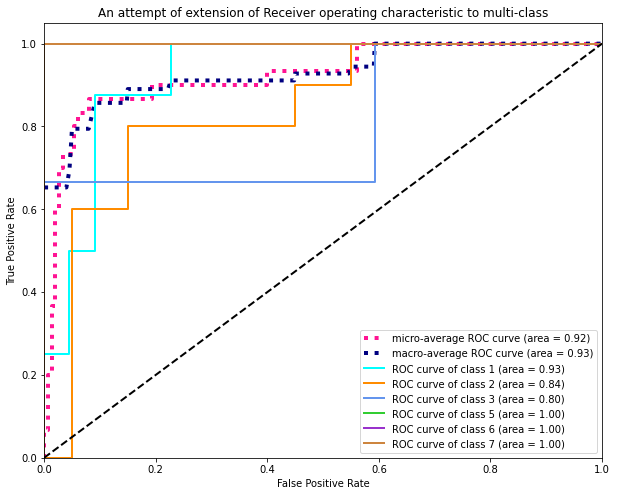

In [3]:
from xgboost.sklearn import XGBClassifier

model_xgb = XGBClassifier(objective='multi:softmax',
                          num_class=6,
                          max_depth=5)

#Given the tiny amount of data left we can't afford to train the algorithm with a validation set :(
model_xgb.fit(X_train, y_train)
print_scores(model_xgb, X_train, X_test, y_train, y_test, '[ XGBOOST ]')
plot_roc(model_xgb, X_test, y_test)

# Model release
---

In [4]:
import pickle

pickl = {'info' : " XGBOOST Classifier\n" +
                  " - Usage: install xgboost package and use with sklearn api:\n"
                  "      from xgboost.sklearn import XGBClassifier\n"
                  " - This model does not require any standarisation.\n" + 
                  " - Trained with " + str(X_train.shape[0]) + " samples\n" +
                  " - Tested with " + str(X_test.shape[0]) + " samples\n",
        'model': model_xgb}
pickle.dump(pickl, open('hg_los_tres_tensores'+'.p','wb'))


In [5]:
#Verify pickle
file_name = 'hg_los_tres_tensores.p'
with open(file_name,'rb') as pickled:
    data = pickle.load(pickled)
    infop =  data['info']
    modelp = data['model']
print(infop)
print(modelp)

 XGBOOST Classifier
 - Usage: install xgboost package and use with sklearn api:
      from xgboost.sklearn import XGBClassifier
 - This model does not require any standarisation.
 - Trained with 87 samples
 - Tested with 30 samples

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=6, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


---
## Helper functions
In order to execute this notebook the following cell needs to be executed before the previous cell. This is counterintuitive and odd but it has been placed last to make the notebook more readable.

In [2]:
def print_scores(model, X_train, X_test, Y_train, Y_test, model_name='[no name]'):
    import sklearn as sk
    from sklearn.metrics import classification_report

    Y_pred = model.predict(X_test)
    print(" "*15,model_name)
    print("Default score:","-"*70)
    print(" Train: %.3f" % model.score(X_train, Y_train))
    print(" Test: %.3f" % model.score(X_test, Y_test))
    print("Other scores:","-"*70)
    print(" Accuracy  : %.3f" % sk.metrics.accuracy_score(Y_test,Y_pred))
    print(" "*12,model.classes_)
    print(" Precision :",sk.metrics.precision_score(Y_test,Y_pred,average=None))
    print(" Recall    :",sk.metrics.recall_score(Y_test,Y_pred,average=None))
    print(" F1        :",sk.metrics.f1_score(Y_test,Y_pred,average=None))
    print(" F1 micro  : %.3f" % sk.metrics.f1_score(Y_test,Y_pred,average='micro'))
    print(" F1 macro  : %.3f" % sk.metrics.f1_score(Y_test,Y_pred,average='macro'))
    print(" Balanced accuracy: %.3f" % sk.metrics.balanced_accuracy_score(Y_test,Y_pred))
    print("-"*85)
    print(classification_report(Y_test,Y_pred))
    print("-"*85)

def plot_roc(model, X_test, Y_test):
    from sklearn.metrics import roc_curve, roc_auc_score, auc
    from scipy import interp
    import matplotlib.pyplot as plt
    from itertools import cycle


    # Let's binarise the classes
    from sklearn.preprocessing import label_binarize
    new_probs = label_binarize(Y_test, classes=[1, 2, 3, 5, 6, 7])

#df_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'threshold':thresholds})

    y_score = model.predict_proba(X_test) #model.decision_function(X_test)
    n_classes = len(model.classes_)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(new_probs[:, i], list(model.predict_proba(X_test)[:, i]), drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(new_probs.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'limegreen', 'darkorchid', 'peru'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(model.classes_[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('An attempt of extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()